In [ ]:
import seagall as sgl
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import distinctipy
%matplotlib inline

In [ ]:
adata=sc.read_h5ad("MouseBrain_GEX.h5ad")
adata

In [ ]:
sgl.ee.geometrical_graph(adata, target_label="CellType", path="SEAGALL")

In [ ]:
adata

In [ ]:
adata.write("MouseBrain_GEX_Step1.h5ad", compression="gzip")

In [3]:
adata=sc.read_h5ad("MouseBrain_GEX_Step1.h5ad")
adata=adata[:250, :250]
adata

View of AnnData object with n_obs × n_vars = 250 × 250
    obs: 'CellType', 'target'
    uns: 'inv_map', 'map'
    obsm: 'GRAE_latent_space'
    layers: 'GRAE_decoded_matrix'
    obsp: 'GRAE_graph'

In [4]:
sgl.ee.classify_and_explain(adata, target_label="CellType", path="SEAGALL", hypopt=0.25)

Thu, 10 Apr 2025 16:23:52 Looking for HPO file
Thu, 10 Apr 2025 16:23:52 HPO .json found
Best value for lr is 0.010376572558743613
Best value for weight_decay is 0.001189744697489247
Best value for dim_h is 96
Best value for heads is 15
Best value for dropout is 0.30000000000000004
Thu, 10 Apr 2025 16:23:52 Creating dataset
Creating pyg dataset based on AnnData object with target label CellType and GRAE's graph. Using 100% of the cells
Thu, 10 Apr 2025 16:23:52 Training model
GAT checkpoint! Best epoch 1 | Best val loss 0.699 | Best val F1 0.777
GAT checkpoint! Best epoch 4 | Best val loss 0.795 | Best val F1 0.821
GAT early stopped at epoch 25 with best epoch 4 | Best val loss: 0.795 | Best val F1: 0.821
Thu, 10 Apr 2025 16:23:54 Metrics for model's performances
Thu, 10 Apr 2025 16:23:54 XAI features extraction


In [5]:
adata

AnnData object with n_obs × n_vars = 250 × 250
    obs: 'CellType', 'target', 'SEAGALL_set', 'SEAGALL_prediction'
    var: 'SEAGALL_Importance_for_Deeper_Layer', 'SEAGALL_Importance_for_Ependymal_cells', 'SEAGALL_Importance_for_IPC', 'SEAGALL_Importance_for_RG_Astro_OPC', 'SEAGALL_Importance_for_Subplate', 'SEAGALL_Importance_for_Upper_Layer', 'SEAGALL_Importance_for_V_SVZ'
    uns: 'inv_map', 'map', 'SEAGALL_Top_50_Specificty'
    obsm: 'GRAE_latent_space'
    layers: 'GRAE_decoded_matrix', 'SEAGALL_Importance'
    obsp: 'GRAE_graph'

In [ ]:
adata.write("MouseBrain_GEX_Step2.h5ad", compression="gzip")

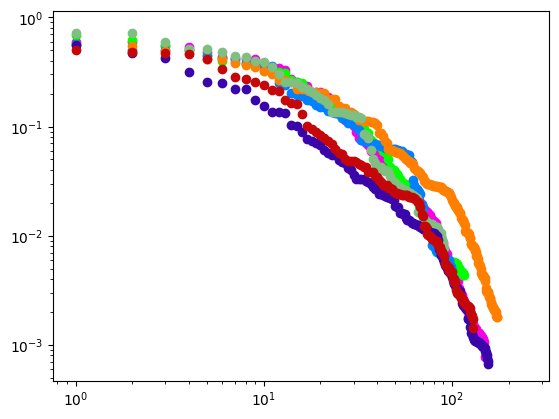

In [7]:
colors = distinctipy.get_colors(len(set(adata.obs.CellType)))
gts = {gt : color for gt, ct in zip(sorted(list(set(adata.obs.CellType))), colors)}
for key, value in gts:
    plt.scatter(x=range(0, len(adata.var)), y=sorted(adata.var[f"SEAGALL_Importance_for_{ct}"])[::-1], c=colors[i])
plt.xscale("Rank")
plt.yscale("Importance")
plt.xscale("log")
plt.yscale("log")

In [ ]:
adata=sc.read_h5ad("Test_Def.h5ad")
label="CellType"
adata

In [ ]:
mydata = sgl.mlu.create_pyg_dataset(adata, label)
mydata = torch_geometric.transforms.RandomNodeSplit(num_val=0.15, num_test=0.15)(mydata)

In [ ]:
model = sgl.mlu.GAT(n_feats=mydata.num_features, n_classes=mydata.num_classes).to(device)
optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(mydata.y), y=mydata.y.numpy())
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float), reduction="mean")
model, history = sgl.mlu.GAT_train_node_classifier(model, mydata, optimizer_model, criterion, "TEMP.pth", epochs=30, patience=5)

In [ ]:
adata.uns["GAT_history"]=history

In [ ]:
model.eval()
pred = model(mydata.x, mydata.edge_index).argmax(dim=1)

adata.obs["SEAGALL_set"] = "--"
adata.obs["SEAGALL_prediction"] = [adata.uns["inv_map"][str(num)] for num in list(pred.cpu().detach().numpy())]
adata.obs.loc[mydata.train_mask.cpu().detach().numpy(),"SEAGALL_set"] = "Train"
adata.obs.loc[mydata.val_mask.cpu().detach().numpy(),"SEAGALL_set"] = "Validation"
adata.obs.loc[mydata.test_mask.cpu().detach().numpy(),"SEAGALL_set"] = "Test"

In [ ]:
explainer = torch_geometric.explain.Explainer(
            model=model,
            algorithm=torch_geometric.explain.GNNExplainer(epochs=30),
            explanation_type='model',
            node_mask_type='attributes',
            edge_mask_type='object',
            model_config=dict(mode='multiclass_classification', task_level='node', return_type='probs'))

In [ ]:
adata.layers["Importance"]=scipy.sparse.csr_matrix(explainer(x=mydata.x, edge_index=mydata.edge_index).node_mask.numpy(), dtype="float32")

In [ ]:
for gt in sorted(set(adata.obs[label])):
    imps = np.array(adata[adata.obs[label]==gt].layers["Importance"].mean(axis=0)).reshape(adata.shape[1], )
    adata.var[f"Importance_for_{gt}"] = imps

In [ ]:
n_feat=50
gts = sorted(set(adata.obs[label]))
jc = pd.DataFrame(index=gts, columns=gts)
for gti in gts:
    for gtj in gts[gts.index(gti)+1:]:
        fsi = adata[adata.obs[label]==gti].var[f"Importance_for_{gti}"].sort_values()[::-1][:int(n_feat)].index
        fsj = adata[adata.obs[label]==gtj].var[f"Importance_for_{gtj}"].sort_values()[::-1][:int(n_feat)].index
        jc.at[gti, gtj] = len(sgl.ut.intersection([fsi, fsj]))/len(sgl.ut.flat_list([fsi, fsj]))

In [ ]:
adata.uns[f"SEAGALL_Top_{n_feat}_Specificty"]=jc.values.astype()

In [ ]:
adata

In [ ]:
adata.write("Test_Def_All.h5ad", compression="gzip")

In [ ]:
pd.DataFrame.from_dict(adata.uns["GAT_history"]).melt()